## Importing Libraries and Modules

In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torchvision import models
from torchvision import transforms
from PIL import Image
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Visualization of the Gestures present in the Dataset

In [3]:
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 1.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

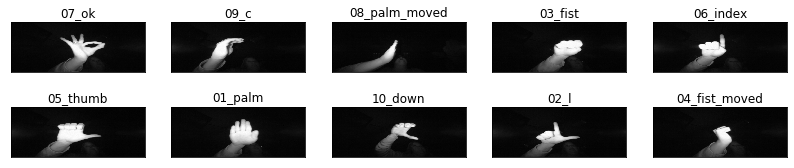

In [4]:
dir = '../dataset'
folders = os.listdir(dir)
folder_person = [dir + '/' + folder for folder in folders][0]
folder_gesture = [folder_person + "/" + gesture for gesture in os.listdir(folder_person)]
gestures = [gesture for gesture in os.listdir(folder_person)]

all_images = []
for i in range(len(folder_gesture)):
    all_images.append(os.listdir(folder_gesture[i])[0])
    
images = []
for i in range(len(folder_gesture)):
    images.append(folder_gesture[i] + "/" + all_images[i])
        
images = np.array([cv2.imread(image, cv2.IMREAD_GRAYSCALE) for image in images])
names = [name for name in gestures]
plot_portraits(images, names, 256, 256, n_row=2, n_col=5)

## AlexNet as a Feature Extractor

In [5]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier = nn.Sequential(*[alexnet.classifier[i] for i in range(5)])

In [6]:
def extractFeatures(img):
    transform = transforms.Compose([            
      transforms.Resize(256),                   
      transforms.CenterCrop(224),               
      transforms.ToTensor(),                    
      transforms.Normalize(                     
      mean=[0.485, 0.456, 0.406],               
      std=[0.229, 0.224, 0.225]                 
    )])
    
    img = img.convert('RGB')
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    out = alexnet(batch_t)
    assert out.shape == torch.Size([1, 4096])
    output = out.detach().numpy()
    output = np.reshape(output, 4096)
    return output

## Reading and Preparing Data

In [7]:
def prepare_data(path):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    i=1
    for folder_person in os.listdir(path):
        for folder_gesture in os.listdir(path + folder_person):
            for file in os.listdir(path + folder_person + "/" + folder_gesture)[0:30]:
                image = Image.open(os.path.join(path + folder_person + "/" + folder_gesture, file))
                if(i<5):
                    image_with_features = extractFeatures(image)
                    X_train.append(image_with_features)
                    y_train.append(int(folder_gesture[0:2]))
                    i+=1
                else:  
                    image_with_features = extractFeatures(image)
                    X_test.append(image_with_features)
                    y_test.append(int(folder_gesture[0:2]))
                    i=1
    return X_train, y_train, X_test, y_test

## Model Building

In [8]:
def model_building(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    return score

## Testing

In [9]:
DATASET_PATH = "../dataset/"
X_train, y_train, X_test, y_test = prepare_data(DATASET_PATH)

In [10]:
models = [(LinearSVC(), "Linear Support Vector"), 
          (RandomForestClassifier(), "Random forest"),
          (KNeighborsClassifier(n_neighbors=10), "KNN with 10 neighbors"),
          (GaussianNB(), "Naive Bayes")]

for model in models:    
    score = model_building(model[0], X_train, X_test, y_train, y_test)
    print("{} score: {}".format(model[1],score))

/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Linear Support Vector score: 0.945
Random forest score: 0.74
KNN with 10 neighbors score: 0.9633333333333334
Naive Bayes score: 0.8033333333333333
